[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0011_aug8.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0011_aug9.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0011_orig.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0012_aug0.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0012_aug1.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0012_aug2.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0012_aug3.png
[Aviso] Máscara não encontrada para ./dataset/Foot-Ulcer-Segmentation-Challenge-v2/labels/train/benchmark_0012_aug4.png
[Aviso] Máscara não encontrada para ./da

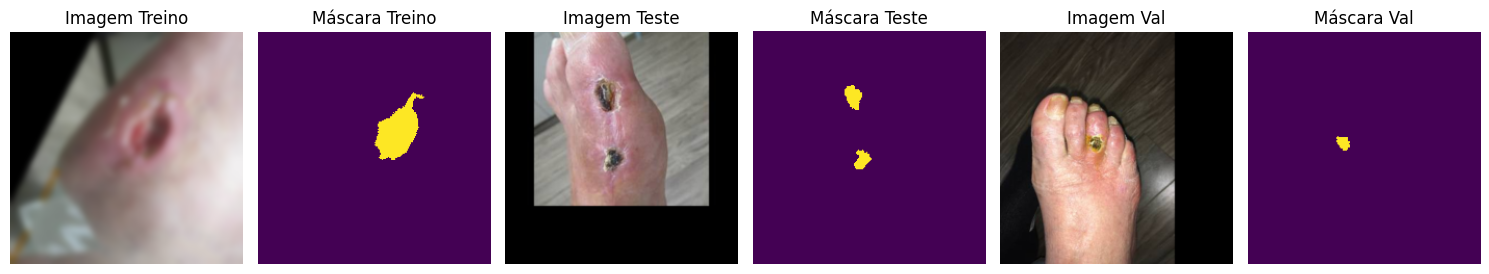

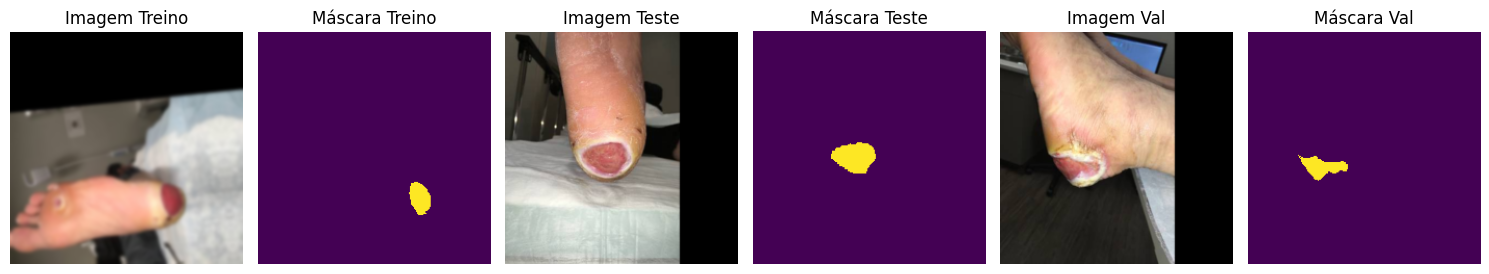

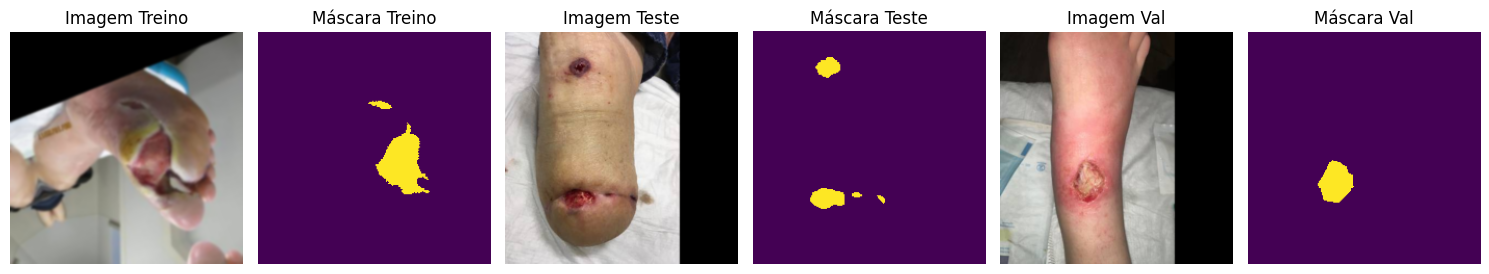

In [4]:
#jupyter nbconvert --to script DatasetReader.ipynb

import os
import config
import sys
sys.path.append('../util')
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from util import show_dataset_prev

class DatasetReader(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # lista apenas .png e ordena para consistência
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

        # monta pares (img_path, mask_path) garantindo mesmo nome
        self.pairs = []
        for img_file in self.image_files:
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, img_file)  # mesmo nome da imagem
            if os.path.exists(mask_path):
                self.pairs.append((img_path, mask_path))
            else:
                print(f"[Aviso] Máscara não encontrada para {mask_dir}/{img_file}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.pairs[idx]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask_np = np.array(mask)
            mask_np = (mask_np > 0).astype(np.uint8) * 255
            mask = Image.fromarray(mask_np)
            mask = self.mask_transform(mask)

        return image, mask


def get_datasets(dataset_dir=config.dataset_path,
                 resolution=config.dataset_resolution,
                 batch_size=config.batch_size,
                 num_workers=4):

    # Transformações
    image_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((resolution, resolution), interpolation=Image.NEAREST),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x > 0.5).float())
    ])

    train_dataset = DatasetReader(
        image_dir=os.path.join(dataset_dir, "images/train"),
        mask_dir=os.path.join(dataset_dir, "labels/train"),
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    val_dataset = DatasetReader(
        image_dir=os.path.join(dataset_dir, "images/valid"),
        mask_dir=os.path.join(dataset_dir, "labels/valid"),
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    test_dataset = DatasetReader(
        image_dir=os.path.join(dataset_dir, "images/test"),
        mask_dir=os.path.join(dataset_dir, "labels/test"),
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True, drop_last=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True, drop_last=False)

    return train_loader, test_loader, val_loader


if __name__ == '__main__':
    train_loader, test_loader, val_loader = get_datasets()
    print(len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset),
          'total:', len(train_loader.dataset) + len(test_loader.dataset) + len(val_loader.dataset))

    show_dataset_prev(train_loader, test_loader, val_loader, num_images=3)
